In [1]:
# importing all important libraries

import math
import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.models import Functional
from keras.saving.saving_api import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
import absl.logging
from keras.initializers.initializers import RandomUniform
from keras.constraints import NonNeg
from sklearn.metrics import roc_curve, precision_recall_curve
absl.logging.set_verbosity(absl.logging.ERROR)
import glob
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
path = '../input/dataset7'

In [3]:
all_files = glob.glob(path + "/*.csv")
all_files

['../input/dataset7/UNSW_IoT_Full5pc_1.csv',
 '../input/dataset7/UNSW__IoT__Full5pc_2.csv',
 '../input/dataset7/UNSW__IoT_Full5pc_4.csv',
 '../input/dataset7/UNSW_IoT_Full5pc_3.csv']

In [4]:
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [5]:
df.head(5)

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,e,1,tcp,1,192.168.100.147,49960,192.168.100.7,80,...,1.12704,96,75,1.133720,1.129970,770,602,1,DoS,HTTP
1,2,1.528089e+09,e,1,arp,2,192.168.100.7,-1,192.168.100.147,-1,...,15267.20000,1,2,0.005142,0.005142,2,6,1,DoS,HTTP
2,3,1.528089e+09,e,1,tcp,1,192.168.100.147,49962,192.168.100.7,80,...,1.12704,96,75,1.135100,1.129970,770,602,1,DoS,HTTP
3,4,1.528089e+09,e,1,tcp,1,192.168.100.147,49964,192.168.100.7,80,...,1.12704,96,75,1.135140,1.129970,770,602,1,DoS,HTTP
4,5,1.528089e+09,e,1,tcp,1,192.168.100.147,49966,192.168.100.7,80,...,1.12704,96,75,1.135260,1.129970,770,602,1,DoS,HTTP


In [6]:
# Getting count of attack column's labels
df['subcategory'].value_counts()

UDP                  1981230
TCP                  1593180
Service_Scan           73168
OS_Fingerprint         17914
HTTP                    2474
Normal                   477
Keylogging                73
Data_Exfiltration          6
Name: subcategory, dtype: int64

In [7]:
# Segregating columns based on thier types

columns = df.columns.tolist()

# categorical columns
nominal = [col for col in columns if df[col].dtype == 'object']

# ordinal columns
discrete = [col for col in columns if df[col].dtype == 'int64']

# continuous columns
continuous = [col for col in columns if df[col].dtype == 'float']

# dissect the dataframe by column types
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

# enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# Making a sample of balanced subset data to use it later if required
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced = pd.concat([df_class_1_subset, df_class_0])

In [8]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')

before enumerating: flgs
e        2293445
e s      1245171
e g        94344
eU         34599
e *          816
e d          137
e &            5
e   t          4
e  D           1
Name: flgs, dtype: int64


after enumerating: flgs
0    2293445
7    1245171
6      94344
8      34599
4        816
5        137
3          5
1          4
2          1
Name: flgs, dtype: int64


before enumerating: proto
udp          1996437
tcp          1662812
icmp            9052
arp              213
ipv6-icmp          8
Name: proto, dtype: int64


after enumerating: proto
4    1996437
3    1662812
1       9052
0        213
2          8
Name: proto, dtype: int64


before enumerating: saddr
192.168.100.147              950966
192.168.100.148              923290
192.168.100.150              890262
192.168.100.149              890146
192.168.100.3                  8281
192.168.100.5                  5118
192.168.100.6                   327
192.168.100.7                    43
192.168.100.4                    19


In [9]:
df

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,0,1,3,1,1,44407,21,6650,...,1.127040,96,75,1.133720,1.129970,770,602,1,1,1
1,2,1.528089e+09,0,1,0,2,12,0,10,0,...,15267.200000,1,2,0.005142,0.005142,2,6,1,1,1
2,3,1.528089e+09,0,1,3,1,1,44409,21,6650,...,1.127040,96,75,1.135100,1.129970,770,602,1,1,1
3,4,1.528089e+09,0,1,3,1,1,44411,21,6650,...,1.127040,96,75,1.135140,1.129970,770,602,1,1,1
4,5,1.528089e+09,0,1,3,1,1,44413,21,6650,...,1.127040,96,75,1.135260,1.129970,770,602,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,2999996,1.528099e+09,0,1,4,3,1,58019,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668518,2999997,1.528099e+09,0,1,4,3,1,58030,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668519,2999998,1.528099e+09,0,1,4,3,1,58041,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7
3668520,2999999,1.528099e+09,0,1,4,3,1,58052,16,6650,...,0.955877,100,52,1.098270,0.955877,1308,780,1,0,7


In [10]:
# Correlation matrix is used to find the correlation between the columns and attack column
## correlation score of 1.0 means that the column is highly (perfectly) correlated with the subject column. Increasing subject value will always increase the other value.
## correlation score of 0.0 means that the column is not correlated with attack column at all
## correlation score -1.0 means that the column is inversely correlated with the subject column. Increasing the subject column value will cause a corresponding decrease in the value of the other column
df.corr()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
pkSeqID,1.000000,-0.243073,-0.274427,-0.254161,0.237317,0.273690,0.005566,0.007401,-0.590200,-0.224795,...,0.116417,0.344897,-0.034067,0.053604,0.057567,0.275888,0.160856,-0.018767,-0.478614,0.130571
stime,-0.243073,1.000000,0.061441,-0.038804,0.180173,0.070712,-0.080864,0.007826,0.026976,0.830622,...,-0.427939,0.095941,0.122517,-0.199616,-0.211940,0.137739,0.154239,0.075162,-0.640137,0.452878
flgs,-0.274427,0.061441,1.000000,0.718275,-0.767601,-0.803181,-0.109793,-0.021071,0.027792,0.054831,...,-0.027721,-0.007546,-0.068004,-0.016105,-0.016396,-0.446892,-0.429715,0.008639,-0.103009,-0.659682
flgs_number,-0.254161,-0.038804,0.718275,1.000000,-0.488383,-0.512343,0.019017,-0.002686,-0.004077,-0.025131,...,0.023426,-0.108676,-0.102976,0.002549,0.005050,-0.298687,-0.279031,0.005521,0.058681,-0.459878
proto,0.237317,0.180173,-0.767601,-0.488383,1.000000,0.940239,-0.046550,0.022225,0.124338,0.195264,...,-0.036549,0.012072,0.081839,-0.020218,-0.024496,0.575714,0.560482,0.001449,-0.012266,0.892094
proto_number,0.273690,0.070712,-0.803181,-0.512343,0.940239,1.000000,0.029158,-0.007922,0.077589,0.034446,...,-0.037283,-0.066941,0.052470,-0.021195,-0.025422,0.567656,0.554534,-0.007329,0.055794,0.871424
saddr,0.005566,-0.080864,-0.109793,0.019017,-0.046550,0.029158,1.000000,-0.007786,-0.440493,-0.119262,...,0.013769,-0.074879,-0.038904,0.010006,0.010449,-0.076650,-0.083931,-0.026496,0.068329,-0.027672
sport,0.007401,0.007826,-0.021071,-0.002686,0.022225,-0.007922,-0.007786,1.000000,0.006216,0.022656,...,0.012448,0.013232,-0.002529,0.005191,0.010963,-0.018001,-0.022310,-0.001217,0.001331,-0.002508
daddr,-0.590200,0.026976,0.027792,-0.004077,0.124338,0.077589,-0.440493,0.006216,1.000000,0.075878,...,-0.019932,-0.259323,0.044876,-0.010496,-0.011235,-0.136886,-0.063728,-0.147924,0.513200,0.080316
dport,-0.224795,0.830622,0.054831,-0.025131,0.195264,0.034446,-0.119262,0.022656,0.075878,1.000000,...,-0.365127,0.119636,0.135833,-0.171444,-0.168446,0.126090,0.140610,0.039805,-0.519266,0.385963


In [11]:
# import seaborn as sns
# # Correlation matrix is used to find the correlation between the columns and attack column
# ## correlation score of 1.0 means that the column is highly (perfectly) correlated with the subject column. Increasing subject value will always increase the other value.
# ## correlation score of 0.0 means that the column is not correlated with attack column at all
# ## correlation score -1.0 means that the column is inversely correlated with the subject column. Increasing the subject column value will cause a corresponding decrease in the value of the other column
# # plotting correlation heatmap
# dataplot=sns.heatmap(df.corr())
  
# # displaying heatmap
# plt.show()

In [12]:
# sorting columns based on the correlation they have with attack column

corr_df = df.corr()['attack']
corr_df = pd.DataFrame(corr_df)
corr_df['attack'] = abs(pd.DataFrame(corr_df)['attack'])
corr_df.sort_values(by=['attack'], ascending=False)

,attack
attack,1.000000
TnP_PerProto,0.786449
TnBPSrcIP,0.286339
TnBPDstIP,0.257277
spkts,0.254066
pkts,0.232678
TnP_PSrcIP,0.229447
sbytes,0.228567
bytes,0.209617
TnP_PDstIP,0.203535


In [13]:
cloned_df = df.copy()
y_df = cloned_df['attack']
x_df = cloned_df

In [14]:
# keeping only most correlated columns and removing those which have less than 1 percent or 0.01 correlation

reduced_columns = list(corr_df[corr_df['attack'] > 0.01].index)
print(reduced_columns)
x_df = x_df[reduced_columns]
x_df.shape

['pkSeqID', 'stime', 'saddr', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'srate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']


(3668522, 33)

In [15]:
# # Correlation Matrix With reduced columns
# import seaborn as sns
# # Correlation matrix is used to find the correlation between the columns and attack column
# ## correlation score of 1.0 means that the column is highly (perfectly) correlated with the subject column. Increasing subject value will always increase the other value.
# ## correlation score of 0.0 means that the column is not correlated with attack column at all
# ## correlation score -1.0 means that the column is inversely correlated with the subject column. Increasing the subject column value will cause a corresponding decrease in the value of the other column
# # plotting correlation heatmap
# dataplot=sns.heatmap(x_df.corr())
  
# # displaying heatmap
# plt.show()

In [16]:
x_df

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1.528089e+09,1,21,6650,8,1980,8,1.528089e+09,9,...,770,772,772,96,75,770,602,1,1,1
1,2,1.528089e+09,12,10,0,2,120,1,1.528089e+09,10,...,2,8,8,1,2,2,6,1,1,1
2,3,1.528089e+09,1,21,6650,8,2126,8,1.528089e+09,11,...,770,772,772,96,75,770,602,1,1,1
3,4,1.528089e+09,1,21,6650,8,2024,8,1.528089e+09,12,...,770,772,772,96,75,770,602,1,1,1
4,5,1.528089e+09,1,21,6650,8,2319,8,1.528089e+09,13,...,770,772,772,96,75,770,602,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,2999996,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109218,...,1308,1308,1308,100,52,1308,780,1,0,7
3668518,2999997,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109219,...,1308,1308,1308,100,52,1308,780,1,0,7
3668519,2999998,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109220,...,1308,1308,1308,100,52,1308,780,1,0,7
3668520,2999999,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109221,...,1308,1308,1308,100,52,1308,780,1,0,7


In [17]:
#Getting count of attack column's labels
x_df['attack'].value_counts()

1    3668045
0        477
Name: attack, dtype: int64

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X = x_df.drop('attack', axis=1)
y = x_df['attack']

In [19]:
X

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PSrcIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,category,subcategory
0,1,1.528089e+09,1,21,6650,8,1980,8,1.528089e+09,9,...,602,770,772,772,96,75,770,602,1,1
1,2,1.528089e+09,12,10,0,2,120,1,1.528089e+09,10,...,6,2,8,8,1,2,2,6,1,1
2,3,1.528089e+09,1,21,6650,8,2126,8,1.528089e+09,11,...,602,770,772,772,96,75,770,602,1,1
3,4,1.528089e+09,1,21,6650,8,2024,8,1.528089e+09,12,...,602,770,772,772,96,75,770,602,1,1
4,5,1.528089e+09,1,21,6650,8,2319,8,1.528089e+09,13,...,602,770,772,772,96,75,770,602,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,2999996,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109218,...,780,1308,1308,1308,100,52,1308,780,0,7
3668518,2999997,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109219,...,780,1308,1308,1308,100,52,1308,780,0,7
3668519,2999998,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109220,...,780,1308,1308,1308,100,52,1308,780,0,7
3668520,2999999,1.528099e+09,1,16,6650,15,900,4,1.528099e+09,109221,...,780,1308,1308,1308,100,52,1308,780,0,7


In [20]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [21]:
y_resampled

0          1
1          1
2          1
3          1
4          1
          ..
7336085    0
7336086    0
7336087    0
7336088    0
7336089    0
Name: attack, Length: 7336090, dtype: int64

In [22]:
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)


In [23]:
df_resampled

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,category,subcategory,attack
0,1,1.528089e+09,1,21,6650,8,1980,8,1.528089e+09,9,...,770,772,772,96,75,770,602,1,1,1
1,2,1.528089e+09,12,10,0,2,120,1,1.528089e+09,10,...,2,8,8,1,2,2,6,1,1,1
2,3,1.528089e+09,1,21,6650,8,2126,8,1.528089e+09,11,...,770,772,772,96,75,770,602,1,1,1
3,4,1.528089e+09,1,21,6650,8,2024,8,1.528089e+09,12,...,770,772,772,96,75,770,602,1,1,1
4,5,1.528089e+09,1,21,6650,8,2319,8,1.528089e+09,13,...,770,772,772,96,75,770,602,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7336085,3577194,1.526350e+09,4,69,5135,1,84,4,1.526350e+09,4262,...,21,123687,24,21,18,21,19,2,3,0
7336086,3577348,1.526352e+09,6,62,5122,2,405,1,1.526352e+09,3785,...,8,142,122,4,74,8,122,2,3,0
7336087,3577208,1.526350e+09,3,9,0,10,600,1,1.526352e+09,5677,...,56,54,54,10,11,50,10,2,3,0
7336088,3576893,1.526344e+09,3,27,5122,2,172,3,1.526344e+09,142,...,7,843,16,3,26,7,161,2,3,0


In [26]:
# r

# **** spilt dataset****

In [27]:
#Getting count of attack column's labels
df_resampled['attack'].value_counts()

1    3668045
0    3668045
Name: attack, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_resampled, test_size=0.2, random_state=123)
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=123)
df_train_0 = df_train.loc[df_resampled['attack'] == 0]
df_train_1 = df_train.loc[df_resampled['attack'] == 1]
df_train_0_x = df_train_0.drop(['attack'], axis=1)
df_train_1_x = df_train_1.drop(['attack'], axis=1)

y = df_train.iloc[:,0:32]

df_valid_0 = df_valid.loc[df_resampled['attack'] == 0]
df_valid_1 = df_valid.loc[df_resampled['attack'] == 1]
df_valid_0_x = df_valid_0.drop(['attack'], axis=1)
df_valid_1_x = df_valid_1.drop(['attack'], axis=1)

df_test_0 = df_test.loc[df_resampled['attack'] == 0]
df_test_1 = df_test.loc[df_resampled['attack'] == 1]
df_test_0_x = df_test_0.drop(['attack'], axis=1)
df_test_1_x = df_test_1.drop(['attack'], axis=1)



In [29]:
y

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PSrcIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,category,subcategory
5615720,3576933,1.526345e+09,6,47,5122,2,967,1,1.526345e+09,6759,...,118038,2,200009,68,1,20,2,26,2,3
5088306,3577284,1.526352e+09,6,57,5122,2,459,1,1.526352e+09,3674,...,1962,3,78955,129,1,29,3,56,2,3
6438477,3576896,1.526344e+09,3,12,1187,5,316,1,1.526345e+09,19,...,188,17,220,28,4,26,14,45,2,3
6499836,3577306,1.526352e+09,6,39,5122,2,946,1,1.526352e+09,3709,...,190,8,142,122,4,74,8,122,2,3
4353211,3577289,1.526352e+09,6,55,5122,2,471,1,1.526352e+09,3681,...,1962,3,78955,129,1,29,3,56,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612341,3612342,1.526345e+09,2,16,2842,2,120,8,1.526345e+09,17773,...,200,200,200,2,100,100,200,200,3,5
4642118,3577125,1.526349e+09,3,40,5122,2,172,2,1.526349e+09,20449,...,23,37,123687,93,18,14,37,12,2,3
1417433,1417434,1.528085e+09,4,16,6650,17,1020,4,1.528085e+09,13691,...,629,629,1196,1196,37,37,629,629,1,7
4283659,3577126,1.526349e+09,6,18,6661,48851,49664771,1,1.526350e+09,5,...,104106,101250,156615,126148,2,11,79752,82556,2,3


In [30]:
# x_train = df_train.drop ('attack', axis=1).values
# y_train1=df_train["attack"].values

In [31]:
# y_train1.shape

In [32]:
df_train.shape, df_test.shape, df_valid.shape

((4695097, 33), (1467218, 33), (1173775, 33))

In [33]:
print("Testing set shape:", df_train_1_x.shape, df_train_0_x.shape)   
print("Testing set shape:", df_test_1_x.shape, df_test_0_x.shape)
print("Training set shape:", df_valid_1_x.shape, df_valid_0_x.shape)

Testing set shape: (2347188, 32) (2347909, 32)
Testing set shape: (734407, 32) (732811, 32)
Training set shape: (586450, 32) (587325, 32)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['attack'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['attack'], axis = 1))

In [35]:
df_train_1_x_rescaled= scaler.transform(df_train_1_x) 

In [36]:
df_test_0_x

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PSrcIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,category,subcategory
5832571,3577281,1.526352e+09,6,26,5122,2,936,1,1.526352e+09,3667,...,1962,4,78955,129,2,29,4,56,2,3
6271253,3577158,1.526349e+09,6,70,5135,1,184,4,1.526349e+09,32816,...,2,19,123687,24,19,1,19,1,2,3
5048007,3576965,1.526345e+09,3,69,5135,1,70,4,1.526345e+09,14555,...,13,24,200009,28,24,9,24,9,2,3
5809855,3577282,1.526352e+09,6,37,5122,2,1310,1,1.526352e+09,3671,...,1962,6,78955,129,3,29,6,56,2,3
6366471,3577282,1.526352e+09,6,28,5122,2,1071,1,1.526352e+09,3668,...,1962,4,78955,129,2,29,4,56,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173117,3577089,1.526348e+09,3,22,5122,2,172,4,1.526348e+09,10433,...,88,18,124664,100,9,13,18,6,2,3
5529868,3577152,1.526349e+09,2,63,5122,2,172,1,1.526349e+09,31729,...,23,39,123687,93,18,14,39,8,2,3
4144680,3577140,1.526349e+09,6,42,5762,1359,327606,4,1.526350e+09,8932,...,1530,1492,140717,1527,1,6,1492,1492,2,3
3746972,3577304,1.526352e+09,6,3,5122,2,981,1,1.526352e+09,3703,...,190,4,142,122,2,74,4,122,2,3


In [37]:
df_train_0_x

,pkSeqID,stime,saddr,daddr,dport,pkts,bytes,state,ltime,seq,...,TnP_PSrcIP,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,category,subcategory
5615720,3576933,1.526345e+09,6,47,5122,2,967,1,1.526345e+09,6759,...,118038,2,200009,68,1,20,2,26,2,3
5088306,3577284,1.526352e+09,6,57,5122,2,459,1,1.526352e+09,3674,...,1962,3,78955,129,1,29,3,56,2,3
6438477,3576896,1.526344e+09,3,12,1187,5,316,1,1.526345e+09,19,...,188,17,220,28,4,26,14,45,2,3
6499836,3577306,1.526352e+09,6,39,5122,2,946,1,1.526352e+09,3709,...,190,8,142,122,4,74,8,122,2,3
4353211,3577289,1.526352e+09,6,55,5122,2,471,1,1.526352e+09,3681,...,1962,3,78955,129,1,29,3,56,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108416,3577158,1.526350e+09,6,2,7256,2873,689626,1,1.526352e+09,40,...,2927,2873,140772,2873,1,6,2873,2873,2,3
5840708,3576893,1.526344e+09,3,19,4214,2,205,3,1.526345e+09,36,...,188,10,699,18,4,26,9,147,2,3
4985707,3576910,1.526344e+09,3,47,4059,1,114,4,1.526344e+09,4102,...,17,8,200009,33,4,11,8,12,2,3
4642118,3577125,1.526349e+09,3,40,5122,2,172,2,1.526349e+09,20449,...,23,37,123687,93,18,14,37,12,2,3


In [38]:
#Getting count of attack column's labels
df_valid['attack'].value_counts()

0    587325
1    586450
Name: attack, dtype: int64

In [39]:
df_train_0_x_rescaled.shape, df_valid_x_rescaled.shape, df_test_x_rescaled.shape, df_test_0_x_rescaled.shape

((2347909, 32), (1173775, 32), (1467218, 32), (732811, 32))

In [40]:
# Print dataset sizes
print("Dataset Splitting Overview:")
print(f"Total samples in df_resampled: {len(df_resampled)}")
print(f"Train set: {len(df_train)} (Normal: {len(df_train_0)}, Anomalous: {len(df_train_1)})")
print(f"Validation set: {len(df_valid)} (Normal: {len(df_valid_0)}, Anomalous: {len(df_valid_1)})")
print(f"Test set: {len(df_test)} (Normal: {len(df_test_0)}, Anomalous: {len(df_test_1)})")


Dataset Splitting Overview:
Total samples in df_resampled: 7336090
Train set: 4695097 (Normal: 2347909, Anomalous: 2347188)
Validation set: 1173775 (Normal: 587325, Anomalous: 586450)
Test set: 1467218 (Normal: 732811, Anomalous: 734407)


In [41]:
import pandas as pd

# Create a table with dataset split information
data_split_table = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Total Samples": [len(df_train), len(df_valid), len(df_test)],
    "Normal Samples": [len(df_train_0), len(df_valid_0), len(df_test_0)],
    "Anomalous Samples": [len(df_train_1), len(df_valid_1), len(df_test_1)]
})

# Print the table
print(data_split_table)


      Dataset  Total Samples  Normal Samples  Anomalous Samples
0       Train        4695097         2347909            2347188
1  Validation        1173775          587325             586450
2        Test        1467218          732811             734407


In [42]:
from tensorflow.keras import backend as K


In [43]:
df_test_x_rescaled.shape

(1467218, 32)

In [44]:
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow.compat.v2 as tf
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.utils.vis_utils import plot_model

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [46]:
# Building Model using multiple layer based autoencoder with non negative weights and biases constraints and sparsity with L1 regularizarion
# and I am using relu activation and RMSProp optimizer with loss function mean squared error.

from keras import regularizers

#input layer
input_dim = df_train_0_x_rescaled.shape[1]

#middle_dim = 100
# latent space
latent_dim = 22
#sparsity_target = 0.1  # desired sparsity level
# output layer
output_dim = 32
# Custom KL divergence regularizer
class KL_Divergence_Regularizer(keras.regularizers.Regularizer):
    def __init__(self, p, p_hat):
        self.p = p
        self.p_hat = p_hat

    def __call__(self, x):
        epsilon = 1e-8  # Small epsilon value
        kl_divergence = self.p * tf.math.log((self.p + epsilon) / (self.p_hat + epsilon)) + (1 - self.p) * tf.math.log((1 - self.p + epsilon) / (1 - self.p_hat + epsilon))
        return kl_divergence

    def get_config(self):
        return {'p': self.p, 'p_hat': self.p_hat}
sparsity_target = 0.3
    # input layer
_input = keras.Input(shape=(input_dim,))

# encoded layer
encoded = layers.Dense(128, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                       activity_regularizer=regularizers.l2(10e-6))(_input)
# # encoded layer
encoded1 = layers.Dense(64, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                        activity_regularizer=regularizers.l2(10e-6))(encoded)
encoded2 = layers.Dense(32, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                        activity_regularizer=regularizers.l2(10e-6))(encoded1)
# latent layer
latent = layers.Dense(latent_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                      activity_regularizer=regularizers.l2(10e-6))(encoded2)

#

#

# decoded layer
decoded = layers.Dense(32, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                       activity_regularizer=regularizers.l2(10e-6))(latent)
decoded1 = layers.Dense(64, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                        activity_regularizer=regularizers.l2(10e-6))(decoded)
decoded2 = layers.Dense(128, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                        activity_regularizer=regularizers.l2(10e-6))(decoded1)
output = layers.Dense(output_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                      activity_regularizer=regularizers.l2(10e-6))(decoded2)

# this model maps an input to its reconstruction
SAE_model = keras.Model(_input, output)
encoded_output = SAE_model.predict(df_train_0_x_rescaled)

# Custom KL divergence regularizer
kl_regularizer = KL_Divergence_Regularizer(sparsity_target, tf.reduce_mean(encoded_output, axis=0))
sparsity_penalty = tf.reduce_mean(kl_regularizer(encoded_output))
weights = SAE_model.get_weights()
print('Weight matrix shapes:', [w.shape for w in weights])
print('Sparsity target:', sparsity_target)
print('Sparsity penalty:', sparsity_penalty.numpy())

73373/73373 [==============================] - 125s 2ms/step
Weight matrix shapes: [(32, 128), (128,), (128, 64), (64,), (64, 32), (32,), (32, 22), (22,), (22, 32), (32,), (32, 64), (64,), (64, 128), (128,), (128, 32), (32,)]
Sparsity target: 0.3
Sparsity penalty: 1.5659789


In [47]:
SAE_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 22)                726       
                                                                 
 dense_4 (Dense)             (None, 32)                736       
                                                                 
 dense_5 (Dense)             (None, 64)                2112  

In [48]:
# weights = SAE_model.get_weights()
# print('Weight matrix shapes:', [w.shape for w in weights])
# print('Sparsity target:', sparsity_target)
# print('Sparsity penalty:', sparsity_penalty.numpy())

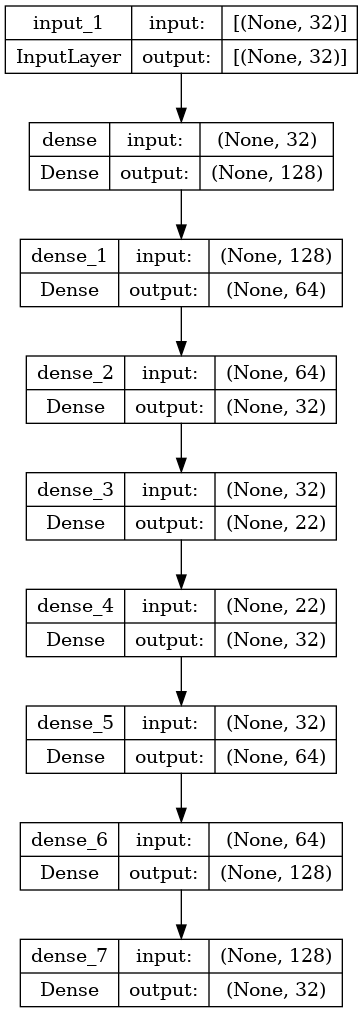

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(SAE_model, to_file='SAE_model.png', show_shapes=True, show_layer_names=True)

In [50]:
output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_7')>

In [51]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [52]:
import time
SAE_model.compile(optimizer=optimizer, loss='mse')

# callback functions
checkpointer = ModelCheckpoint(filepath=f"SAE_mode",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)
# Record the start time
start_time = time.time()
# train the autoencoder
history = SAE_model.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                        epochs=10,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                        callbacks=[checkpointer, tensorboard]).history
# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/10
9172/9172 [==============================] - 64s 7ms/step - loss: 54249.1836 - val_loss: 0.5513
Epoch 2/10
9172/9172 [==============================] - 58s 6ms/step - loss: 0.5517 - val_loss: 0.5513
Epoch 3/10
9172/9172 [==============================] - 62s 7ms/step - loss: 0.5515 - val_loss: 0.5509
Epoch 4/10
9172/9172 [==============================] - 58s 6ms/step - loss: 0.5515 - val_loss: 0.5510
Epoch 5/10
9172/9172 [==============================] - 59s 6ms/step - loss: 0.5514 - val_loss: 0.5513
Epoch 6/10
9172/9172 [==============================] - 59s 6ms/step - loss: 0.5514 - val_loss: 0.5509
Epoch 7/10
9172/9172 [==============================] - 61s 7ms/step - loss: 0.5514 - val_loss: 0.5509
Epoch 8/10
9172/9172 [==============================] - 59s 6ms/step - loss: 0.5514 - val_loss: 0.5509
Epoch 9/10
9172/9172 [==============================] - 61s 7ms/step - loss: 0.5514 - val_loss: 0.5508
Epoch 10/10
9172/9172 [==============================] - 58s 6ms/step

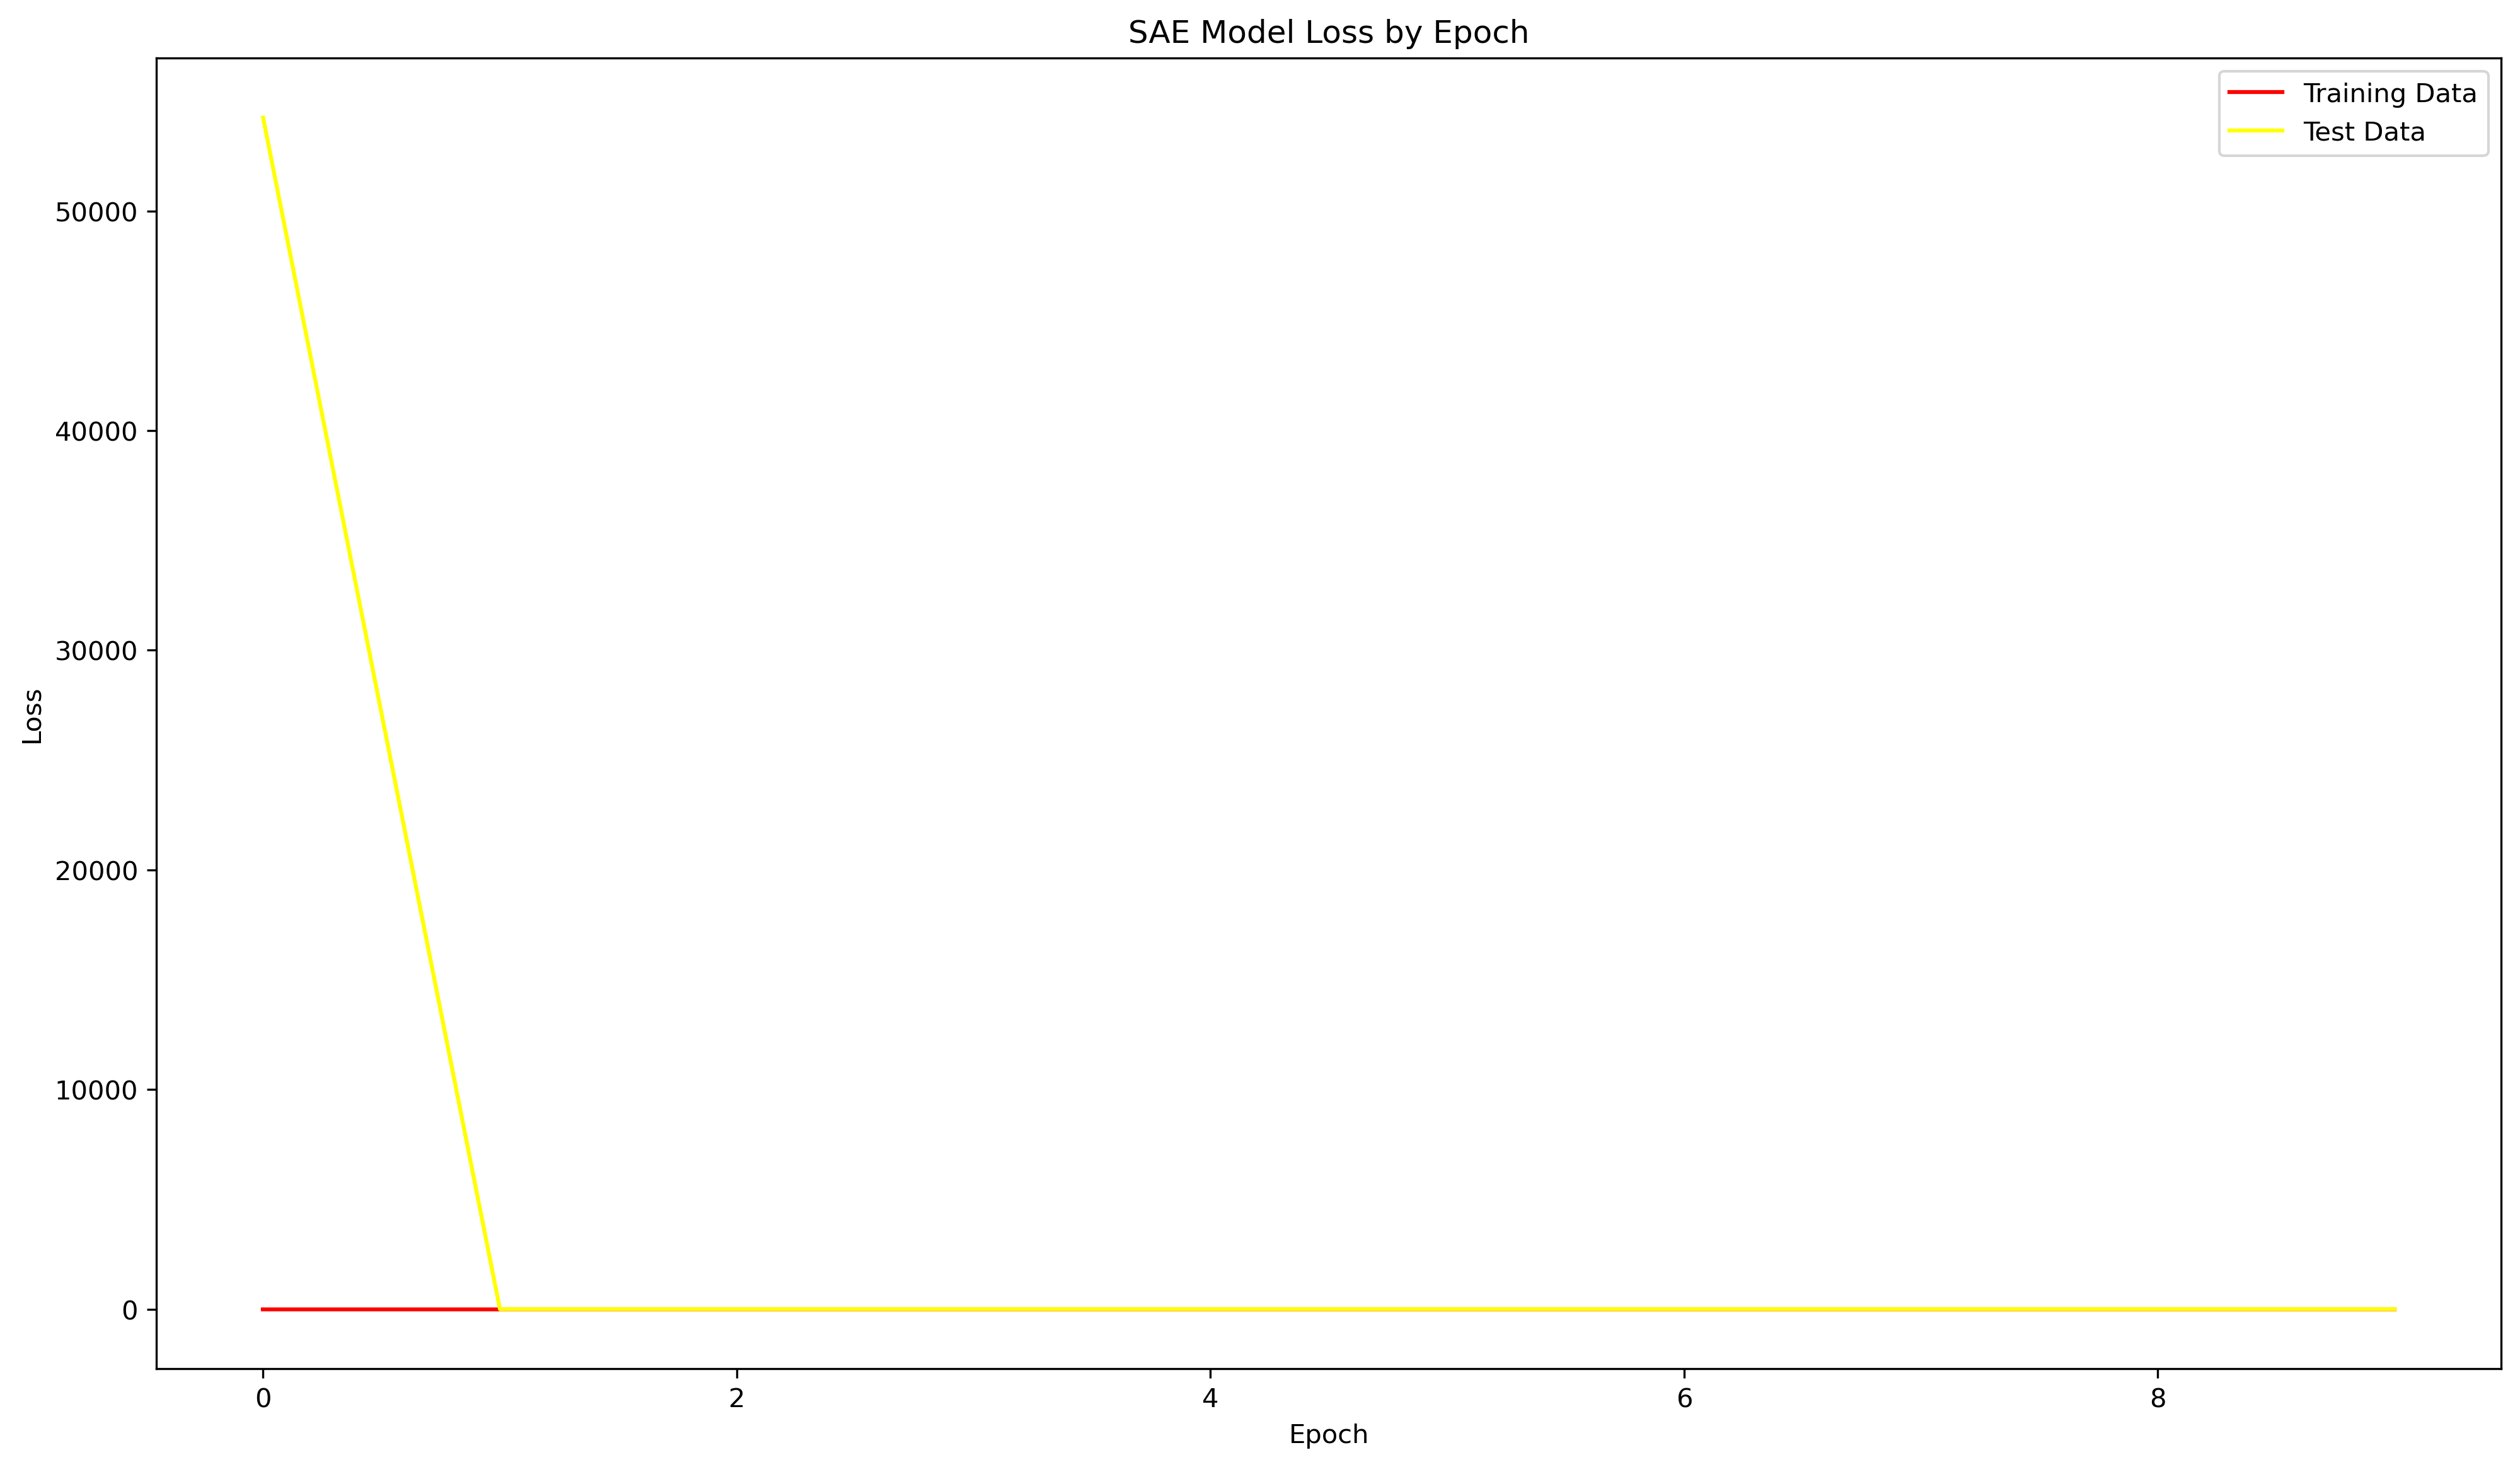

<Figure size 640x480 with 0 Axes>

In [53]:
Sfig, ax = plt.subplots(figsize=(16, 9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(history['val_loss'], label='Training Data', color='red')
ax.plot(history['loss'], label='Test Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()

plt.show()
plt.savefig('train_val_loss.png')

1/1 [==============================] - 0s 32ms/step


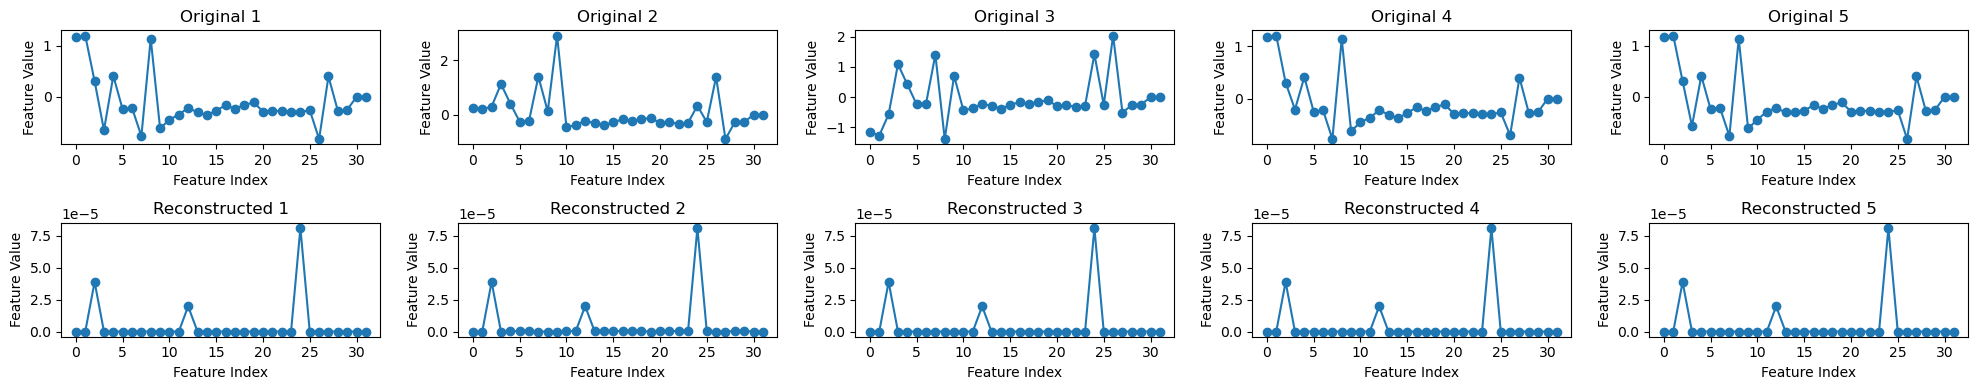

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Generate reconstructed samples using the trained autoencoder
reconstructed_samples = SAE_model.predict(df_test_0_x_rescaled[:10])  # Adjust the number of samples to plot as needed

# Select original samples for comparison
original_samples = df_test_0_x_rescaled[:5]

# Plot original and reconstructed samples
n_samples = original_samples.shape[0]
n_features = original_samples.shape[1]

plt.figure(figsize=(4 * n_samples, 4))

for i in range(n_samples):
    # Plot original sample
    plt.subplot(2, n_samples, i + 1)
    plt.plot(original_samples[i], marker='o')
    plt.title(f'Original {i + 1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    # Plot reconstructed sample
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.plot(reconstructed_samples[i], marker='o')
    plt.title(f'Reconstructed {i + 1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

plt.tight_layout()
plt.show()

In [59]:
# Generate reconstructed samples for test and validation data
reconstructed_test = SAE_model.predict(df_test_0_x_rescaled)
reconstructed_valid = SAE_model.predict(df_valid_0_x_rescaled)

# Compute MSE for test and validation data
mse_test = np.mean(np.power(df_test_0_x_rescaled - reconstructed_test, 2), axis=1)
mse_valid = np.mean(np.power(df_valid_0_x_rescaled - reconstructed_valid, 2), axis=1)

# Print the mean reconstruction error
print(f'Mean Reconstruction Error on Test Data: {np.mean(mse_test)}')
print(f'Mean Reconstruction Error on Validation Data: {np.mean(mse_valid)}')

18354/18354 [==============================] - 32s 2ms/step
Mean Reconstruction Error on Test Data: 0.5506375796938173
Mean Reconstruction Error on Validation Data: 0.5506850115612126


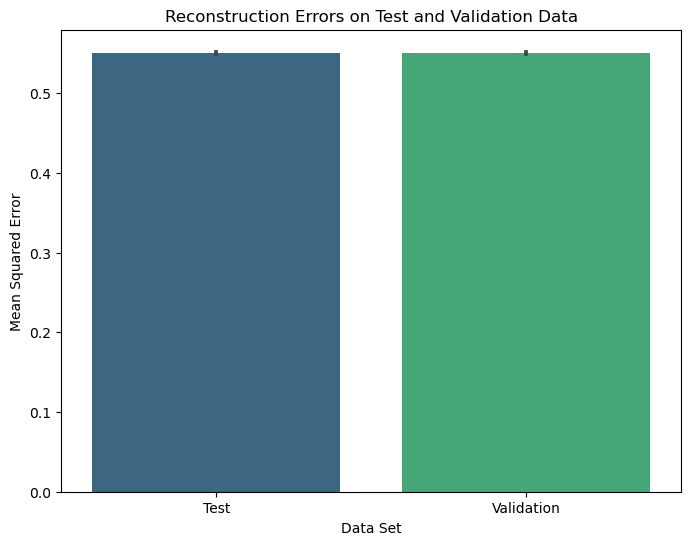

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine MSE values and labels for plotting
errors = np.concatenate([mse_test, mse_valid])
labels = ['Test'] * len(mse_test) + ['Validation'] * len(mse_valid)

# Create a DataFrame for visualization
error_df = pd.DataFrame({'Error': errors, 'Set': labels})

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Set', y='Error', data=error_df, palette='viridis')
plt.title('Reconstruction Errors on Test and Validation Data')
plt.xlabel('Data Set')
plt.ylabel('Mean Squared Error')
plt.show()

In [61]:
df_test_x_rescaled.shape

(1467218, 32)

45851/45851 [==============================] - 82s 2ms/step


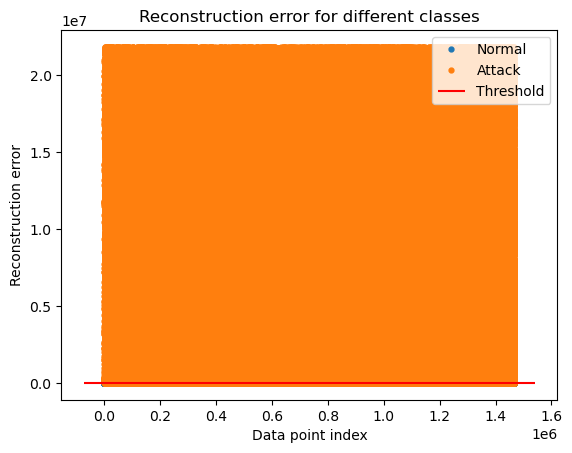

In [62]:
test_x_predictions = SAE_model.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['attack']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 3.5
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=150, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

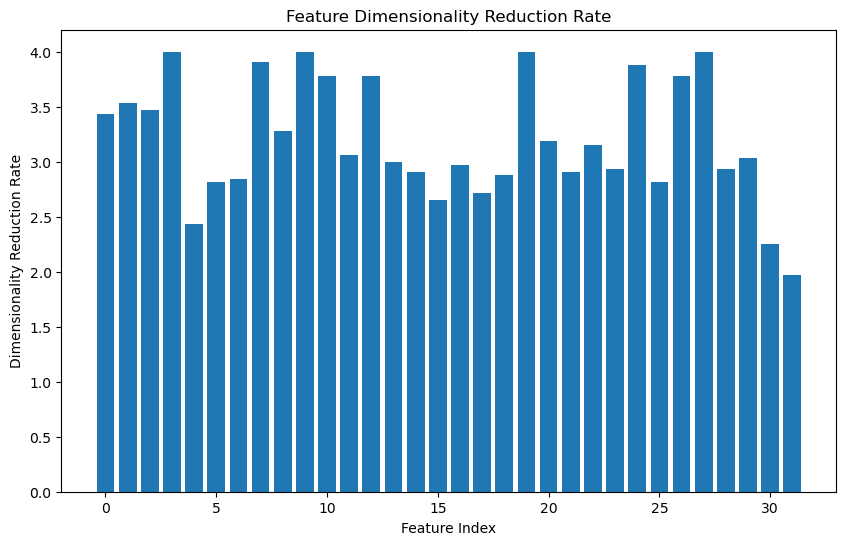

In [63]:
encoder_weights = SAE_model.layers[1].get_weights()[0]  # Assuming the encoder layer is the second layer

# Calculate the dimensionality reduction rate for each feature
reduction_rate = np.count_nonzero(encoder_weights, axis=1) / encoder_weights.shape[0]

# Plot the dimensionality reduction rate for each feature
plt.figure(figsize=(10, 6))
plt.bar(range(input_dim), reduction_rate)
plt.xlabel('Feature Index')
plt.ylabel('Dimensionality Reduction Rate')
plt.title('Feature Dimensionality Reduction Rate')
plt.show()

In [64]:
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow.compat.v2 as tf
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.utils.vis_utils import plot_model
import seaborn as sns

In [65]:
y_pred = SAE_model.predict(df_test_x_rescaled)

45851/45851 [==============================] - 82s 2ms/step


In [66]:
# Calculate the reconstruction error
#X_train_decoded = autoencoder.predict(X_train)
X_test_decoded = SAE_model.predict(df_test_x_rescaled)
train_reconstruction_error = np.mean(np.square(df_train_0_x_rescaled - encoded_output), axis=1)
test_reconstruction_error = np.mean(np.square(df_test_x_rescaled - X_test_decoded), axis=1)

45851/45851 [==============================] - 82s 2ms/step


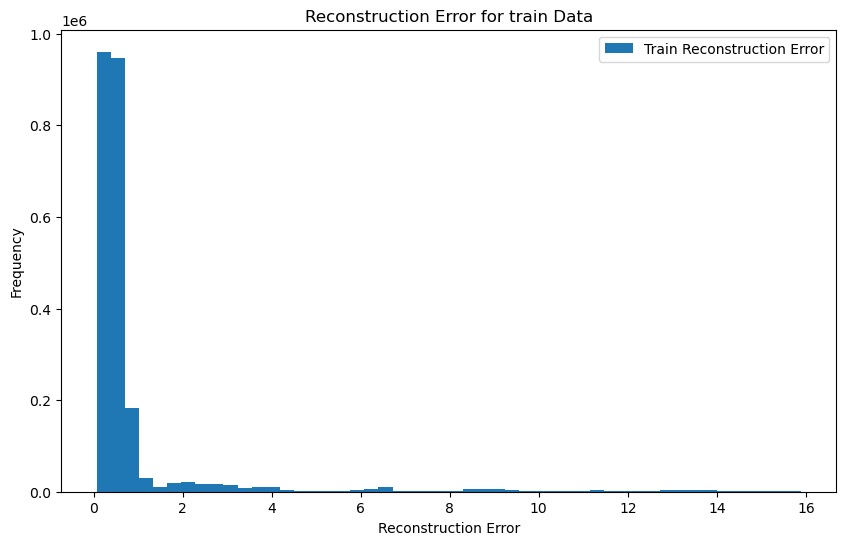

In [67]:
# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(train_reconstruction_error, bins=50, label='Train Reconstruction Error')
#plt.hist(test_reconstruction_error, bins=50, label='Test Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error for train Data')
plt.legend()

# Specify the directory where you want to save the image
output_directory = "/kaggle/working/"

# Save the plot with high quality
output_file = os.path.join(output_directory, 'reconstruction_error_plot.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')  # Adjust dpi for desired quality

plt.show()

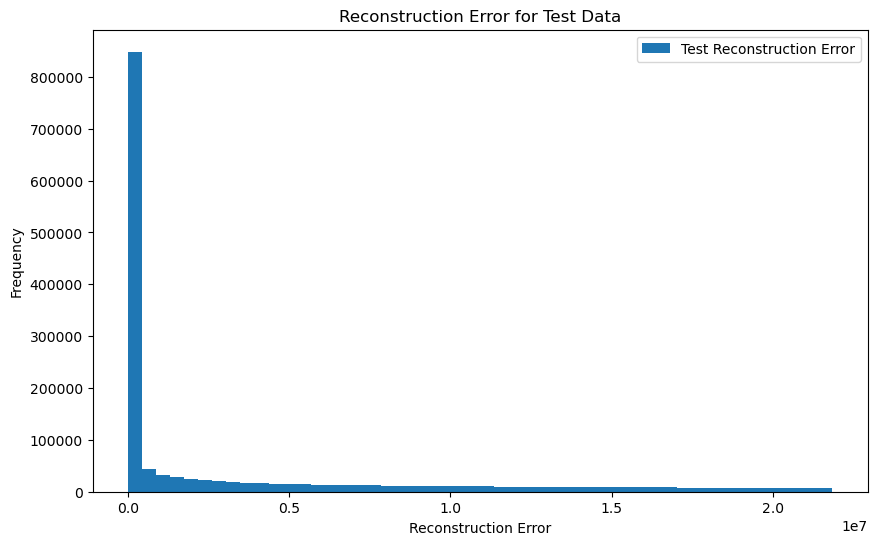

In [68]:
# Plot the reconstruction error
plt.figure(figsize=(10, 6))
#plt.hist(train_reconstruction_error, bins=50, label='Train Reconstruction Error')
plt.hist(test_reconstruction_error, bins=50, label='Test Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error for Test Data')
plt.legend()

# Specify the directory where you want to save the image
output_directory = "/kaggle/working/"

# Save the plot with high quality
output_file = os.path.join(output_directory, 'reconstruction_error_test_plot.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')  # Adjust dpi for desired quality

plt.show()

In [69]:
LABELS = ["Normal", "Attack"]

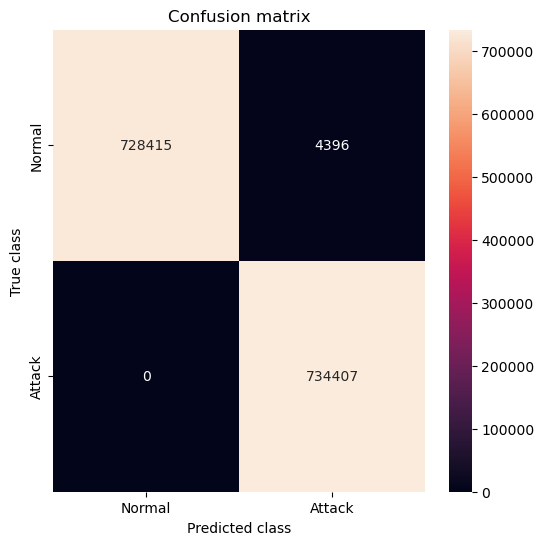

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    732811
           1       0.99      1.00      1.00    734407

    accuracy                           1.00   1467218
   macro avg       1.00      1.00      1.00   1467218
weighted avg       1.00      1.00      1.00   1467218



In [70]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
report = classification_report(error_df_test.True_class, pred_y)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print("Classification Report:")
print(report)


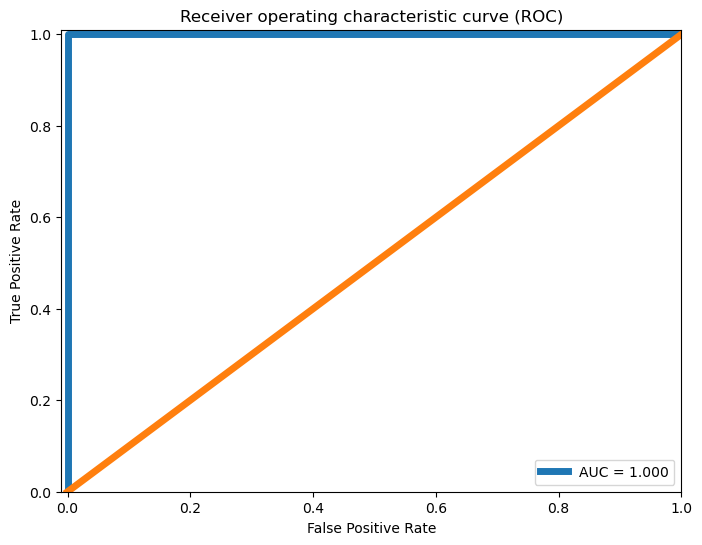

In [73]:
import matplotlib.pyplot as plt
import os

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.figure(figsize=(8, 6))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Specify the directory where you want to save the image
output_directory = "/kaggle/working/"

# Save the plot with high quality
output_file = os.path.join(output_directory, 'roc_curve_plot.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')  # Adjust dpi for desired quality

plt.show()

In [75]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)
 
# Driver Code
lst = false_pos_rate
average = Average(lst)
 
# Printing average of the list
print("false_pos_rate =", round(average, 2))

false_pos_rate = 0.39


In [76]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)
 
# Driver Code
lst = true_pos_rate
average = Average(lst)
 
# Printing average of the list
print("true_pos_rate =", round(average, 2))

true_pos_rate = 1.0


In [77]:
# Calculate accuracy, precision, recall, and F1 score from the confusion matrix
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))
print("Recall: {:.2%}".format(recall))
print("F1 Score: {:.2%}".format(f1_score))

Accuracy: 99.70%
Precision: 99.40%
Recall: 100.00%
F1 Score: 99.70%


In [78]:
encoded_valid_0_x = SAE_model.predict(df_train_0_x_rescaled)
encoded_valid_1_x = SAE_model.predict(df_train_1_x_rescaled)

73350/73350 [==============================] - 133s 2ms/step
